# **Deep Neural Network for MNIST Classification**

---



---



## **RELEVANT PACKAGES**

---



In [ ]:
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

## **DATA**


---







In [26]:
mnist_dataset,mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True ,download = True)
# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# as_supervised=True will load the dataset in a 2-tuple structure (input, target)


mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']


# by default, TF has training and testing datasets, but no validation sets
# thus we must split it on our own

# we start by defining the number of validation samples as a % of the train samples
# this is also where we make use of mnist_info (we don't have to count the observations)
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
# let's cast this number to an integer, as a float may cause an error along the way
num_validation_samples = tf.cast(num_validation_samples, tf.int64)


# let's also store the number of test samples in a dedicated variable (instead of using the mnist_info one)
num_test_samples = mnist_info.splits['test'].num_examples
# once more, we'd prefer an integer (rather than the default float)
num_test_samples = tf.cast(num_test_samples, tf.int64)

# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
def scale(image, label):

  image = tf.cast(image, tf.float32)
  # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
  # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1
  image /=255
  return image, label


# the method .map() allows us to apply a custom transformation to a given dataset
# we have already decided that we will get the validation data from mnist_train, so
scaled_train_and_validation_data = mnist_train.map(scale)

# finally, we scale and batch the test data
# we scale it so it has the same magnitude as the train and validation
# there is no need to shuffle it, because we won't be training on the test data
# there would be a single batch, equal to the size of the test data
test_data = mnist_test.map(scale)

# let's also shuffle the data

BUFFER_SIZE = 10000
# this BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets
# then we can't shuffle the whole dataset in one go because we can't fit it all in memory
# so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# if BUFFER_SIZE >= num samples => shuffling is uniform
# BUFFER_SIZE in between - a computational optimization to approximate uniform shuffling

shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
# our validation data would be equal to 10% of the training set, which we've already calculated
# we use the .take() method to take that many samples
# finally, we create a batch with a batch size equal to the total number of validation samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)


# determine the batch size
BATCH_SIZE = 100

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

# **MODEL**

---



## Outline the model

In [27]:
input_size = 784    # 28*28 = 784
output_size = 10
hidden_layer_size = 50 # Using same hidden layer size for both hidden layers.

model = tf.keras.Sequential([

                             # the first layer (the input layer)
                             # each observation is 28x28x1 pixels, therefore it is a tensor of rank 3
                             # there is a convenient method 'Flatten' that simply takes our 28x28x1 tensor and orders it into a (None,)
                             # or (28x28x1,) = (784,) vector
                             # this allows us to actually create a feed forward neural network
                             tf.keras.layers.Flatten(input_shape = (28,28,1)), # input layer

                              # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
                             tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'), # 1st hidden layer
                             tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'), # 2nd hidden layer

                             # the final layer is no different, we just make sure to activate it with softmax
                             tf.keras.layers.Dense(output_size, activation = 'softmax') # output layer
])

## Choose the optimizer and the loss function


In [28]:
# we define the optimizer we'd like to use,
# the loss function,
# and the metrics we are interested in obtaining at each iteration
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Training

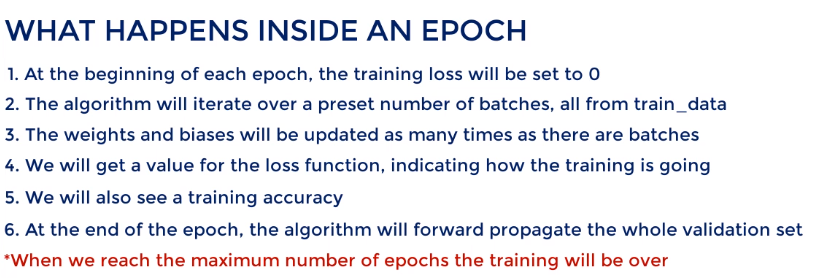

In [29]:
NUM_EPOCHS = 5

# we fit the model, specifying the
# training data
# the total number of epochs
# and the validation data we just created ourselves in the format: (inputs,targets)
model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose =2)

Epoch 1/5
540/540 - 6s - loss: 0.4183 - accuracy: 0.8805 - val_loss: 0.2397 - val_accuracy: 0.9285 - 6s/epoch - 11ms/step
Epoch 2/5
540/540 - 3s - loss: 0.1898 - accuracy: 0.9450 - val_loss: 0.1628 - val_accuracy: 0.9537 - 3s/epoch - 6ms/step
Epoch 3/5
540/540 - 3s - loss: 0.1449 - accuracy: 0.9579 - val_loss: 0.1258 - val_accuracy: 0.9635 - 3s/epoch - 5ms/step
Epoch 4/5
540/540 - 3s - loss: 0.1140 - accuracy: 0.9663 - val_loss: 0.1103 - val_accuracy: 0.9677 - 3s/epoch - 6ms/step
Epoch 5/5
540/540 - 3s - loss: 0.0985 - accuracy: 0.9706 - val_loss: 0.1085 - val_accuracy: 0.9678 - 3s/epoch - 5ms/step


# **Test the model**


---





In [30]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 1s 784ms/step - loss: 0.1166 - accuracy: 0.9648


In [31]:
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.12. Test accuracy: 96.48%
